In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dropout, Dense, LSTM
from keras.callbacks import CSVLogger, History, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_fscore_support
from pandas_ml import ConfusionMatrix
%matplotlib inline

class YelpLSTM(object):
    def __init__(self, parms):
        self._parms = parms
        self._tokenizer = Tokenizer(nb_words=self._parms['vocabulary_size'])
        self._reviews = None
        self._balanced = None
        self._glove = None
        self._embedding_matrix = None
        self._model = None
        self._verbose = True
        self._predicted_classes = None
        self._predicted_proba = None
        self._eval_actual = None
        self._eval_predicted_proba = None
        self._eval_predicted_classes = None
        self._logs = None
        self._tpr = None
        self._fpr = None
        self._thresholds = None
        self._auc = None
        self._target_range = None
        
    def console(self, message):
        if self._verbose:
            print(message)
            
    def update_parms(self, parms):
        if parms['vocabulary_size'] != self._parms['vocabulary_size']:
            self._tokenizer = Tokenizer(nb_words=parms['vocabulary_size'])
        self._parms = parms
        
    def load_reviews(self, reviews):
        self.console('Loading reviews...')
        self._reviews = pd.read_csv(reviews)
        self.console('%d reviews loaded.' % len(self._reviews))
        
    def load_glove(self, glove_folder):
        self.console('Loading GloVe embeddings...')
        glove = {}
        count = 0
        with open(os.path.join(glove_folder, 'glove.6B.' + str(self._parms['embedding_dim']) + 'd.txt'), 'r') as f:
            while True:
                line = f.readline()
                if not line:
                    break
                line = line.split(' ')
                word = line[0]
                vector = np.asarray(line[1:], dtype='float32')
                glove[word] = vector
        self._glove = glove
        self.console('%d embeddings loaded.' % len(self._glove))
        
    @property
    def training(self):
        return self._X_train, self._y_train
    
    @property
    def test(self):
        return self._X_test, self._y_test
    
    @property
    def best_model(self):
        return self._model
    
    @property
    def predicted_classes(self):
        return self._predicted_classes
    
    @property
    def predicted_proba(self):
        return self._predicted_proba
    
    @property
    def tokenizer(self):
        return self._tokenizer
    
    @property
    def logs(self):
        return self._logs
        
    @property
    def confusion_matrix(self):
        return self._cm
    
    @property
    def prfs(self):
        return self._prfs
    
    @property
    def fpr(self):
        return self._fpr
    
    @property
    def tpr(self):
        return self._tpr
    
    @property
    def thresholds(self):
        return self._thresholds
    
    @property
    def auc(self):
        return self._auc
        
    def _balance_dataset(self):
        categories = []
        samples = []
                
        self._target_range = range(2)
        if self._parms['target']['feature'] == 'stars':
            prefix = ''
            self._target_range = range(1,6)
        else:
            prefix = 'is_'
            self._reviews['is_' + self._parms['target']['feature']] = self._reviews[self._parms['target']['feature']].apply(lambda v: v > self._parms['target']['threshold']).astype(int)
            
        for i in self._target_range:
            categories.append(self._reviews[self._reviews[prefix + self._parms['target']['feature']] == i])
            
        sizes = map(lambda s: len(s), categories)
        nb_samples = min(self._parms['samples'], np.min(sizes))
        self.console('Using %s samples per category' % str(nb_samples))
        
        for category in categories:
            samples.append(category.sample(n=nb_samples, random_state=32))
        self._balanced = pd.concat(samples)

    def _build_datasets(self):
        self._tokenizer.fit_on_texts(self._balanced.text.values)
        
        sequences = self._tokenizer.texts_to_sequences(self._balanced.text)
        padded_seq = pad_sequences(sequences, maxlen=self._parms['seq_size'])

        if self._parms['target']['feature'] == 'stars':
            target = to_categorical(self._balanced[self._parms['target']['feature']])
        else:
            target = self._balanced['is_' + self._parms['target']['feature']].values

        self._X_train, self._X_test, self._y_train, self._y_test = train_test_split(padded_seq, target, test_size=0.2, random_state=42)

    def _build_embeddings(self):
        tokenized_words = map(lambda t: t[0], sorted(self._tokenizer.word_index.items(), key=lambda t: t[1])[:self._parms['vocabulary_size']])

        embedding_matrix = np.zeros((self._parms['vocabulary_size'], self._parms['embedding_dim']))
        for idx, word in enumerate(tokenized_words):
            try:
                embedding_matrix[idx] = self._glove[word]
            except:
                pass
        self._embedding_matrix = embedding_matrix

    def _build_model(self):
        model = Sequential()

        model.add(Embedding(input_dim=self._parms['vocabulary_size'],
                            output_dim=self._parms['embedding_dim'],
                            input_length=self._parms['seq_size'],
                            weights=[self._embedding_matrix],
                            trainable=False))

        model.add(LSTM(self._parms['memory_neurons']))
        model.add(Dropout(0.2))

        activation = 'sigmoid'
        loss = 'binary_crossentropy'
        outputs = 1
        if len(self._y_train.shape) > 1:
            activation = 'softmax'
            loss = 'categorical_crossentropy'
            outputs = self._y_train.shape[1]

        model.add(Dense(outputs, activation=activation))
        model.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])
        self._model = model
        self.console(self._model.summary())

    def fit(self, model_name, folder='./', verbose=True):
        self._verbose = verbose
        
        assert self._reviews is not None, 'Reviews file was not loaded'
        assert len(self._reviews) > 0, 'Reviews file is empty'
        assert self._glove is not None, 'GloVe file was not loaded'
        assert len(self._glove) > 0, 'GloVe file is empty'
        
        self.console('Balancing dataset...')
        self._balance_dataset()
        self.console('Building training and test datasets...')
        self._build_datasets()
        self.console('Building word embeddings from GloVe...')
        self._build_embeddings()
        self.console('Building model...')
        self._build_model()
        self.console('Fitting model...')
        
        parms_desc = model_name + '_%ddim_%dvoc_%dseq' % (self._parms['embedding_dim'],
                                                          self._parms['vocabulary_size'],
                                                          self._parms['seq_size'])

        hist = History()
        logger = CSVLogger(os.path.join(folder, parms_desc) + '_training_logs.csv')
        checks = ModelCheckpoint(os.path.join(folder, parms_desc) + '_model-{epoch:02d}_{val_acc:.2f}',
                                 monitor='val_acc',
                                 verbose=int(self._verbose),
                                 save_best_only=True,
                                 mode='max')
        early_stopping = EarlyStopping(monitor='val_acc', patience=2)

        self._model.fit(self._X_train,
                        self._y_train,
                        nb_epoch=self._parms['nb_epochs'],
                        batch_size=self._parms['batch_size'],
                        validation_data=(self._X_test, self._y_test),
                        callbacks=[checks, hist, logger, early_stopping])
        
        self._logs = pd.read_csv(os.path.join(folder, parms_desc) + '_training_logs.csv')
        best_epoch = self._logs['val_acc'].argmax()
        best_val_acc = '{:.2f}'.format(self._logs['val_acc'].iloc[best_epoch])
        best_model = (os.path.join(folder, parms_desc) + '_model-%02d_%s') % (best_epoch, best_val_acc)
        
        with open(os.path.join(folder, parms_desc + '_tokenizer'), 'wb') as tok:
            pickle.dump(self._tokenizer, tok)
        
        self.console('Calculating predictions for the best model...')
        self._model = load_model(best_model)
        self._predicted_proba = self.predict_proba()
        if len(self._y_train.shape) > 1:
            self._predicted_classes = np.argmax(self._predicted_proba, axis=1)
        else:
            self._predicted_classes = (self._predicted_proba > 0.5).astype(int)
        self.console('Calculating metrics for the best model...')
        self.evaluate()
        self.console('Finished!')
        
        return self._model

    def load(self, tokenizer, model):
        error_msg = ''
        try:
            self._model = load_model(model)
        except:
            error_msg = 'Error loading model!'
            
        try:
            with open(tokenizer, 'rb') as tok:
                self._tokenizer = pickle.load(tok)
        except:
            error_msg = 'Error loading tokenizer!'
            
        return (error_msg == ''), error_msg
    
    def make_prediction(self, sentence):
        sequence = self._tokenizer.texts_to_sequences([sentence])
        padded_seq = pad_sequences(sequence, maxlen=self._parms['seq_size'])
        return self.predict_classes(padded_seq)[0]
    
    def predict_classes(self, X=None, threshold=0.5):
        if len(self._y_train.shape) > 1:
            predictions = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = (self.predict_proba(X) > threshold).astype(int)
        return predictions
        
    def predict_proba(self, X=None):
        if X is None:
            X = self._X_test
        predictions = self._model.predict_proba(X)
        return predictions
    
    def evaluate(self, actual=None, predicted_proba=None, threshold=0.5):
        if actual is None:
            eval_actual = self._y_test[:]
        else:
            eval_actual = actual[:]
            
        if predicted_proba is None:
            eval_predicted_proba = self._predicted_proba[:]
        else:
            eval_predicted_proba = predicted_proba[:]
            
        if len(eval_actual.shape) == 1:
            binary = True
            eval_predicted_classes = (eval_predicted_proba > threshold).astype(int).ravel()
            eval_predicted_proba = eval_predicted_proba.ravel()
        else:
            binary = False
            eval_predicted_classes = eval_predicted_proba.argmax(axis=1)
            eval_actual = eval_actual.argmax(axis=1)
        
        self._eval_actual = eval_actual
        self._eval_predicted_proba = eval_predicted_proba
        self._eval_predicted_classes = eval_predicted_classes
    
        self._cm = ConfusionMatrix(self._eval_actual, self._eval_predicted_classes)

        prfs = precision_recall_fscore_support(y_true=self._eval_actual, y_pred=self._eval_predicted_classes)
        prfs = pd.DataFrame.from_dict(dict(zip(['precision', 'recall', 'fscore', 'support'], prfs)))
        prfs.set_index([self._target_range], inplace=True)
        self._prfs = prfs
        
        if binary:
            self._fpr, self._tpr, self._thresholds = roc_curve(self._eval_actual, self._eval_predicted_proba)
            self._auc = auc(self._fpr, self._tpr)
        else:
            self._fpr, self._tpr, self._thresholds, self._auc = None, None, None, None

Using TensorFlow backend.


In [2]:
reviews = './dataset/english_reviews_sample.csv'
glove_folder = './glove.6B'

In [7]:
parms = {'embedding_dim': 100,
         'vocabulary_size': 10000,
         'seq_size': 400,
         'nb_epochs': 30,
         'batch_size': 128,
         'memory_neurons': 100,
         'target': {'feature': 'stars', 'threshold': None},
         'samples': 62500}

lstm = YelpLSTM(parms)

In [8]:
lstm.load_reviews(reviews)

Loading reviews...
410050 reviews loaded.


In [9]:
lstm.load_glove(glove_folder)

Loading GloVe embeddings...
400000 embeddings loaded.


In [11]:
model = lstm.fit(model_name='stars_100neurons', folder='./models/stars')

Balancing dataset...
Using 35197 samples per category
Building training and test datasets...
Building word embeddings from GloVe...
Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 400, 100)      1000000     embedding_input_1[0][0]          
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 100)           80400       embedding_1[0][0]                
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100)           0           lstm_1[0][0]                     
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 6)

/home/dvgodoy/Programs/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


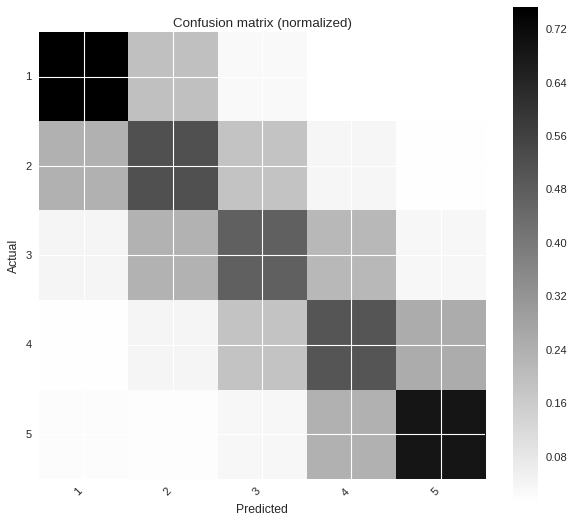

In [12]:
lstm.confusion_matrix.plot(normalized=True)

In [13]:
lstm.prfs

,fscore,precision,recall,support
1,0.726618,0.702008,0.753016,6964
2,0.519833,0.519136,0.520532,7062
3,0.493429,0.516169,0.472608,6991
4,0.504778,0.503434,0.506129,7097
5,0.687945,0.686639,0.689256,7083


In [14]:
lstm.make_prediction('i will never go there again, food was awful')

1/1 [==============================] - 0s


1

In [15]:
lstm.make_prediction('most wonderful place i have ever been, food is amazing')

1/1 [==============================] - 0s


5

In [16]:
lstm.make_prediction('food is amazing and service is good')

1/1 [==============================] - 0s


4

In [17]:
lstm.make_prediction('well, i am not sure, food was ok, but service was good')

1/1 [==============================] - 0s


3

In [18]:
lstm.make_prediction('well, i am not sure, food was ok, but service was awful')

1/1 [==============================] - 0s


2